In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display

## Section 1: Data Wrangling & Exploratory Data Analysis

<b>Importing Dataset</b>

In [3]:
df = pd.read_csv("IoT_dataset.csv")
df.columns
df

,DATE_TIME,POWER
0,21-04-2021 23:30,0.0
1,21-04-2021 23:45,0.0
2,22-04-2021 00:00,0.0
3,22-04-2021 00:15,0.0
4,22-04-2021 00:30,0.0
...,...,...
659,28-04-2021 22:15,0.0
660,29-04-2021 06:15,0.0
661,29-04-2021 06:30,0.0
662,29-04-2021 06:45,0.0


In [4]:
df['DATE_TIME']= pd.to_datetime(df['DATE_TIME'],format='%d-%m-%Y %H:%M')

In [5]:
df.dtypes

DATE_TIME    datetime64[ns]
POWER               float64
dtype: object

## Setting Index 
For time series data manipulation, we'll set the the DATE_TIME column as the index using the Pandas DateTime Index.

In [6]:
df.set_index('DATE_TIME', inplace=True)

In [7]:
df.index

DatetimeIndex(['2021-04-21 23:30:00', '2021-04-21 23:45:00',
               '2021-04-22 00:00:00', '2021-04-22 00:15:00',
               '2021-04-22 00:30:00', '2021-04-22 00:45:00',
               '2021-04-22 01:00:00', '2021-04-22 01:15:00',
               '2021-04-22 01:30:00', '2021-04-22 01:45:00',
               ...
               '2021-04-28 21:00:00', '2021-04-28 21:15:00',
               '2021-04-28 21:30:00', '2021-04-28 21:45:00',
               '2021-04-28 22:00:00', '2021-04-28 22:15:00',
               '2021-04-29 06:15:00', '2021-04-29 06:30:00',
               '2021-04-29 06:45:00', '2021-04-29 07:00:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=664, freq=None)

The 'DatetimeIndex' is a different from the ordinary index and it offers more functionality for time series data wrangling.

The output indicates the days of the month we're working with and the week of the year.

<b> Grouping data on an hourly basis.<b>

In [8]:
df['POWER'] = df['POWER'].resample('H').mean()

In [9]:
# Dropping empty rows
df = df.dropna()

In [10]:
df.head()

,POWER
DATE_TIME,
2021-04-22 00:00:00,0.0
2021-04-22 01:00:00,0.0
2021-04-22 02:00:00,0.0
2021-04-22 03:00:00,0.0
2021-04-22 04:00:00,0.0


### Plotting Time Series Data

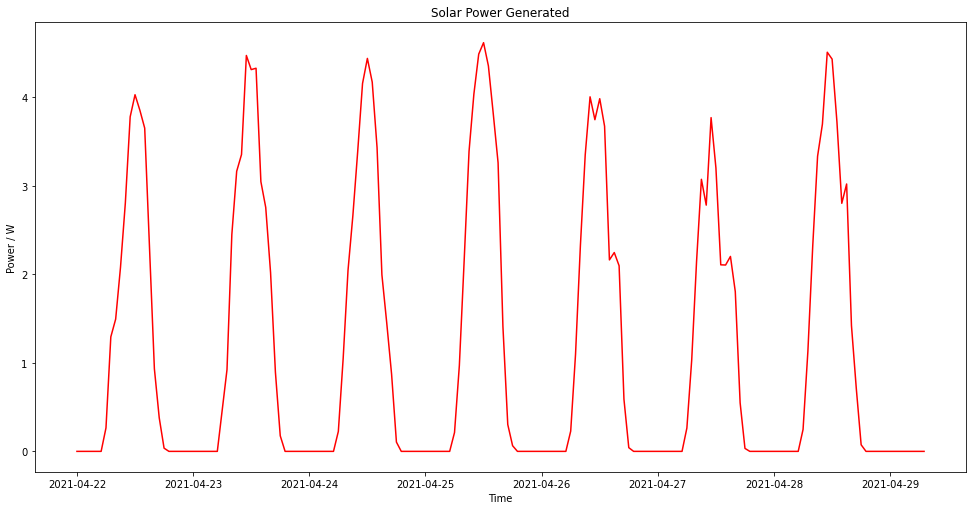

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax.set(xlabel='Time', ylabel='Power / W', title='Solar Power Generated')
sns.lineplot(data = df, x = 'DATE_TIME', y='POWER', color = 'red' );

Now that we have prepared our data. We'll now proceed towards towards modeling our time series data.

## Section 2: Data Transformation

## 1. Decomposition

Time Series data can be decomposed into two categories:
<b>
    
1.ADDITIVE<br>
2.MULTIPLICATIVE</b>

Additive time Series : $O_{t} = T_{t} + S_{t} + R_{t}$ 

Multiplicative time Series : $O_{t} = T_{t} * S_{t} * R_{t}$ 


Where,<br>
$O_{t}$ is the output   
$T_{t}$ is the trend  
$S_{t}$ is the seasonality  
$R_{t}$ is the residual  
$_t$ is a variable representing a particular point in time 

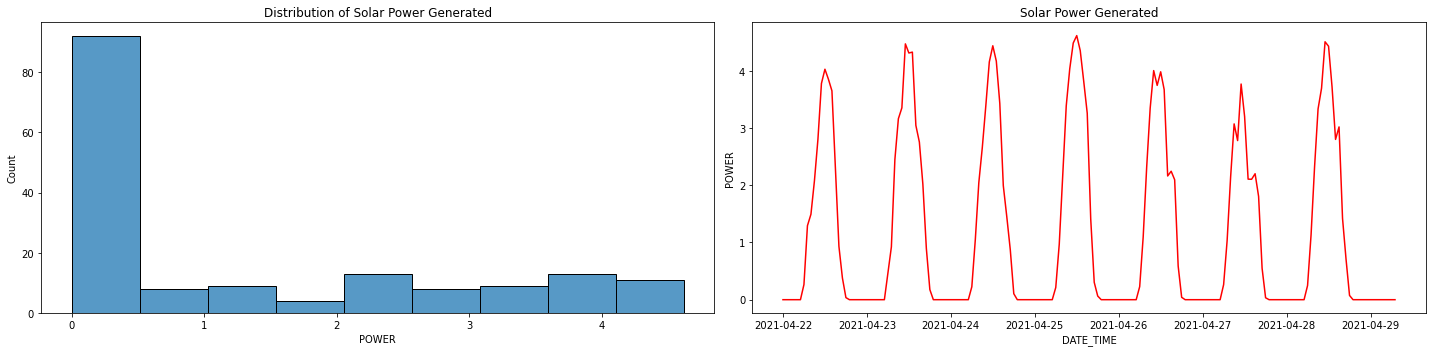

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,5))
sns.histplot(df['POWER'],ax = ax1);
sns.lineplot(data = df, x = 'DATE_TIME', y='POWER', color = 'red', ax = ax2 );
ax1.set(title='Distribution of Solar Power Generated');
ax2.set(title = 'Solar Power Generated');
fig.tight_layout()

Visually, there's no trend in our data but it has strong seasonality as the solar panel generates power during the day and peaks at midday when the intensity of the sun is the strongest. 

Our TS is additive in nature. We'll find out the right period to remove the seasonality.

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decomposition = seasonal_decompose(x=df['POWER'], model='additive', period=24)
estimated_trend = ts_decomposition.trend
estimated_seasonal = ts_decomposition.seasonal
estimated_residual = ts_decomposition.resid

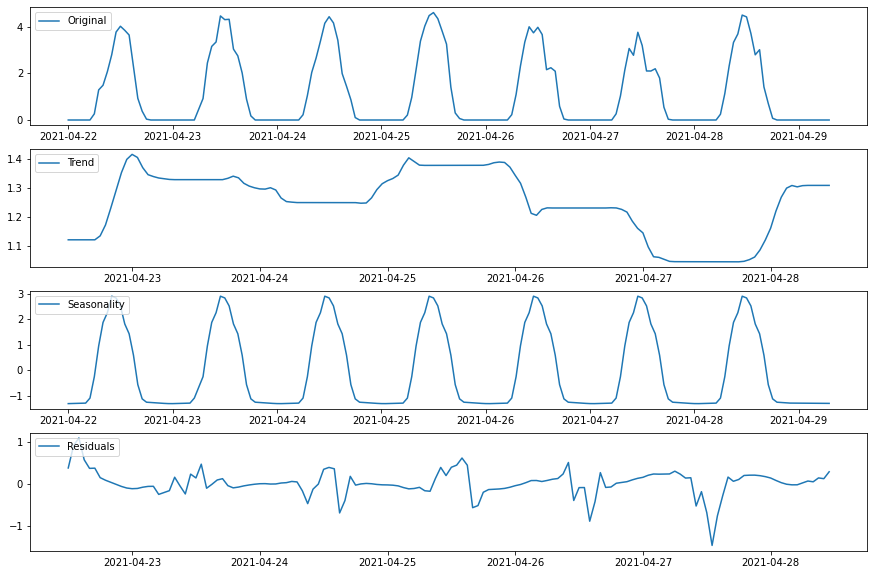

In [13]:
fig, axes = plt.subplots(4, 1)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df['POWER'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

A period of 24 captures the seasonality and trend. While there is some deviation in the beginning, it appears to be built in and barring that the residuals are fairly stationary. 

Let's take the seasonal difference of our data to remove the seasonality

In [14]:
df['lag_24h'] = df.POWER.shift(24)
df['seasonal_diff'] = df.POWER - df['lag_24h']

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


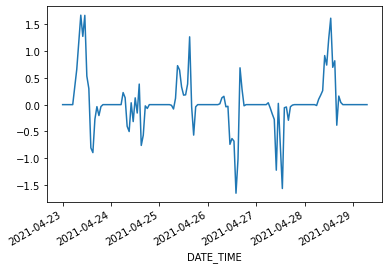

In [15]:
df['seasonal_diff'].plot();